In [1]:
from astropy.table import Table
from astropy.io import ascii
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const

from matplotlib.gridspec import GridSpec
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

In [2]:
def calc_Noverg(line_flux, line_name, flux_err=None):
    #format - A, wavelength, Eupper, g_J
    line_dict = {'H2_10_S2':[3.98e-7, 2.0338, 7584, 9], 'H2_10_S1':[3.47e-7, 2.1218, 6956, 21],
                'H2_10_S0':[2.53e-7, 2.2235, 6471, 5], 'H2_21_S1':[4.98e-7, 2.2477, 12550, 21],
                'H2_21_S2':[5.60e-7, 2.1542, 13150, 9], 'H2_21_S3':[5.77e-7, 2.0735, 13890, 33],
                'H2_10_Q1':[4.29e-7, 2.4066, 6149, 9]}
    
    line_A, line_wave, Eupper, g_J = line_dict[line_name]
    Noverg = 4*np.pi*(line_wave*u.micron)/(const.h * const.c) * (line_flux*u.erg/u.s/(u.cm**2)) / (line_A/u.s)
    
    Noverg = Noverg.decompose().to(u.cm**-2) / g_J
    
    if flux_err is not None:
        flux_cal_uncert = 0.2 #20% flux calibration uncertainty
        
        flux_err = np.sqrt(flux_err**2 + (flux_cal_uncert * line_flux)**2)
        
        Noverg_err = 4*np.pi*(line_wave*u.micron)/(const.h * const.c) * (flux_err*u.erg/u.s/(u.cm**2)) / (line_A/u.s)
        Noverg_err = Noverg_err.decompose().to(u.cm**-2) / g_J
    
        return Noverg, Eupper, Noverg_err

    else:
        return Noverg, Eupper

In [3]:
def linfunc(x, a, b):
    return a*x + b

In [4]:
tab_100pc = Table.read('/Users/jotter/highres_PSBs/ngc1266_NIFS/fit_output/NIFS_100pc_fluxes.csv')
tab_50pc = Table.read('/Users/jotter/highres_PSBs/ngc1266_NIFS/fit_output/NIFS_50pc_fluxes_cent.csv')
tab_A = Table.read('/Users/jotter/highres_PSBs/ngc1266_NIFS/fit_output/NIFS_50pc_fluxes_x22y42.csv')
tab_B = Table.read('/Users/jotter/highres_PSBs/ngc1266_NIFS/fit_output/NIFS_50pc_fluxes_x62y22.csv')

tab_ann = Table.read('/Users/jotter/highres_PSBs/ngc1266_NIFS/fit_output/NIFS_ann_300pc_fluxes.csv')

cal_uncert = 0.05 #calibration uncertainty


A_10_S1_err = np.sqrt(tab_A['H2(1-0)S(1)_flux_err'][0]**2 + (cal_uncert * tab_A['H2(1-0)S(1)_flux'][0])**2)
A_21_S1_err = np.sqrt(tab_A['H2(2-1)S(1)_flux_err'][0]**2 + (cal_uncert * tab_A['H2(2-1)S(1)_flux'][0])**2)
ratio_21_10_A = tab_A['H2(2-1)S(1)_flux'][0] / tab_A['H2(1-0)S(1)_flux'][0]
ratio_21_10_A_err = ratio_21_10_A * np.sqrt((A_21_S1_err / tab_A['H2(2-1)S(1)_flux'][0])**2 + 
                              (A_10_S1_err/tab_A['H2(1-0)S(1)_flux'][0])**2)

B_10_S1_err = np.sqrt(tab_B['H2(1-0)S(1)_flux_err'][0]**2 + (cal_uncert * tab_B['H2(1-0)S(1)_flux'][0])**2)
B_21_S1_err = np.sqrt(tab_B['H2(2-1)S(1)_flux_err'][0]**2 + (cal_uncert * tab_B['H2(2-1)S(1)_flux'][0])**2)
ratio_21_10_B = tab_B['H2(2-1)S(1)_flux'][0] / tab_B['H2(1-0)S(1)_flux'][0]
ratio_21_10_B_err = ratio_21_10_B * np.sqrt((B_21_S1_err/tab_B['H2(2-1)S(1)_flux'][0])**2 + 
                              (B_10_S1_err/tab_B['H2(1-0)S(1)_flux'][0])**2)

ctr_10_S1_err = np.sqrt(tab_50pc['H2(1-0)S(1)_flux_err'][0]**2 + (cal_uncert * tab_50pc['H2(1-0)S(1)_flux'][0])**2)
ctr_21_S1_err = np.sqrt(tab_50pc['H2(2-1)S(1)_flux_err'][0]**2 + (cal_uncert * tab_50pc['H2(2-1)S(1)_flux'][0])**2)
ratio_21_10_ctr = tab_50pc['H2(2-1)S(1)_flux'][0] / tab_50pc['H2(1-0)S(1)_flux'][0]
ratio_21_10_ctr_err = ratio_21_10_ctr * np.sqrt((ctr_21_S1_err/tab_50pc['H2(2-1)S(1)_flux'][0])**2 + 
                              (ctr_10_S1_err/tab_50pc['H2(1-0)S(1)_flux'][0])**2)

A_10_S2_err = np.sqrt(tab_A['H2(1-0)S(2)_flux_err'][0]**2 + (cal_uncert * tab_A['H2(1-0)S(2)_flux'][0])**2)
A_10_S0_err = np.sqrt(tab_A['H2(1-0)S(0)_flux_err'][0]**2 + (cal_uncert * tab_A['H2(1-0)S(0)_flux'][0])**2)
ratio_s2s0_A = tab_A['H2(1-0)S(2)_flux'][0] / tab_A['H2(1-0)S(0)_flux'][0]
ratio_s2s0_A_err = ratio_s2s0_A * np.sqrt((A_10_S2_err / tab_A['H2(1-0)S(2)_flux'][0])**2 + 
                              (A_10_S0_err/tab_A['H2(1-0)S(0)_flux'][0])**2)

B_10_S2_err = np.sqrt(tab_B['H2(1-0)S(2)_flux_err'][0]**2 + (cal_uncert * tab_B['H2(1-0)S(2)_flux'][0])**2)
B_10_S0_err = np.sqrt(tab_B['H2(1-0)S(0)_flux_err'][0]**2 + (cal_uncert * tab_B['H2(1-0)S(0)_flux'][0])**2)
ratio_s2s0_B = tab_B['H2(1-0)S(2)_flux'][0] / tab_B['H2(1-0)S(0)_flux'][0]
ratio_s2s0_B_err = ratio_s2s0_B * np.sqrt((B_10_S2_err / tab_B['H2(1-0)S(2)_flux'][0])**2 + 
                              (B_10_S0_err/tab_B['H2(1-0)S(0)_flux'][0])**2)

ctr_10_S2_err = np.sqrt(tab_50pc['H2(1-0)S(2)_flux_err'][0]**2 + (cal_uncert * tab_50pc['H2(1-0)S(2)_flux'][0])**2)
ctr_10_S0_err = np.sqrt(tab_50pc['H2(1-0)S(0)_flux_err'][0]**2 + (cal_uncert * tab_50pc['H2(1-0)S(0)_flux'][0])**2)
ratio_s2s0_ctr = tab_50pc['H2(1-0)S(2)_flux'][0] / tab_50pc['H2(1-0)S(0)_flux'][0]
ratio_s2s0_ctr_err = ratio_s2s0_ctr * np.sqrt((ctr_10_S2_err / tab_50pc['H2(1-0)S(2)_flux'][0])**2 + 
                              (ctr_10_S0_err/tab_50pc['H2(1-0)S(0)_flux'][0])**2)

H2_brgamma_ctr = tab_50pc['H2(1-0)S(0)_flux'][0]/tab_50pc['Brgamma_flux'][0]
H2_brgamma_A = tab_A['H2(1-0)S(0)_flux'][0]/tab_A['Brgamma_flux'][0]
H2_brgamma_B = tab_B['H2(1-0)S(0)_flux'][0]/tab_B['Brgamma_flux'][0]


Tvib_ctr = 5600/np.log(1.355 / ratio_21_10_ctr)
Trot_ctr = -1113/np.log(0.323 * ratio_s2s0_ctr)
Tvib_A = 5600/np.log(1.355 / ratio_21_10_A)
Trot_A = -1113/np.log(0.323 * ratio_s2s0_A)
Tvib_B = 5600/np.log(1.355 / ratio_21_10_B)
Trot_B = -1113/np.log(0.323 * ratio_s2s0_B)


z = 0.007214
D_L = cosmo.luminosity_distance(z).to(u.Mpc)
as_per_kpc = cosmo.arcsec_per_kpc_comoving(z)

In [5]:
##Loading in U19
U19 = ascii.read('/Users/jotter/highres_PSBs/tables/U19_tab2.txt')

ratio_21_10_U = U19['2-1_S(1)/1-0_S(1)']
e_ratio_21_10_U = U19['e_2-1_S(1)/1-0_S(1)']

noulim_ind_21_U = np.where(e_ratio_21_10_U > 0)
ulim_ind_21_U = np.where(e_ratio_21_10_U < 0) #no galaxies with upper limit measurements

ratio_s2s1_U = U19['1-0_S(2)/1-0_S(1)']
e_ratio_s2s1_U = U19['e_1-0_S(2)/1-0_S(1)']

ratio_s0s1_U = U19['1-0_S(0)/1-0_S(1)']
e_ratio_s0s1_U = U19['e_1-0_S(0)/1-0_S(1)']

ratio_s2s0_U = ratio_s2s1_U/ratio_s0s1_U
e_ratio_s2s0_U = ratio_s2s0_U * np.sqrt((e_ratio_s2s1_U/ratio_s2s1_U)**2 + (e_ratio_s0s1_U/ratio_s0s1_U)**2)

noulim_ind_s2s1_U = np.where(e_ratio_s2s1_U > 0)
ulim_ind_s2s0_U = np.where(e_ratio_s2s1_U < 0)
noulim_ind_s0s1_U = np.where(e_ratio_s0s1_U > 0)
llim_ind_s2s0_U = np.where(e_ratio_s0s1_U < 0)

noulim_ind_s2s0_U = np.intersect1d(noulim_ind_s2s1_U, noulim_ind_s0s1_U)

noulim_ind_U = np.intersect1d(noulim_ind_21_U, noulim_ind_s2s0_U)
noulim_ind_U = np.delete(noulim_ind_U, 0)

Tvib_U = 5600/np.log(1.355 / ratio_21_10_U)
Trot_U = -1113/np.log(0.323 * ratio_s2s0_U)



#Loading in AGN from Riffel 2013
riffel13 = Table.read('/Users/jotter/highres_PSBs/tables/Riffel_table4.csv')

r13_21_S1 = riffel13['H2(2-1)S(1)']
e_r13_21_S1 = riffel13['e_H2(2-1)S(1)']
r13_21_S1_ulim = np.where(e_r13_21_S1 == -1, True, False)
r13_21_S1_nolim = np.logical_not(r13_21_S1_ulim)
    
r13_10_S1 = riffel13['H2(1-0)S(1)']
e_r13_10_S1 = riffel13['e_H2(1-0)S(1)']
r13_10_S1_ulim = np.where(e_r13_10_S1 == -1, True, False)
r13_10_S1_nolim = np.logical_not(r13_10_S1_ulim)
        
r13_10_S2 = riffel13['H2(1-0)S(2)']
e_r13_10_S2 = riffel13['e_H2(1-0)S(2)']
r13_10_S2_ulim = np.where(e_r13_10_S2 == -1, True, False)
r13_10_S2_nolim = np.logical_not(r13_10_S2_ulim)

r13_10_S0 = riffel13['H2(1-0)S(0)']
e_r13_10_S0 = riffel13['e_H2(1-0)S(0)']
r13_10_S0_llim = np.where(e_r13_10_S0 == -2, True, False)
r13_10_S0_nolim = np.logical_not(r13_10_S0_llim)

r13_brgamma = riffel13['Brgamma']
e_r13_brgamma = riffel13['e_Brgamma']

ratio_21_10_r13 = r13_21_S1 / r13_10_S1
ratio_21_10_r13_nolim = np.logical_and(r13_21_S1_nolim, r13_10_S1_nolim)
e_ratio_21_10_r13 = ratio_21_10_r13 * np.sqrt((e_r13_21_S1/r13_21_S1)**2 + (e_r13_10_S1/r13_10_S1)**2)

ratio_s2s0_r13 = r13_10_S2 / r13_10_S0
ratio_s2s0_r13_nolim = np.logical_and(r13_10_S2_nolim, r13_10_S0_nolim)
e_ratio_s2s0_r13 = ratio_s2s0_r13 * np.sqrt((e_r13_10_S2/r13_10_S2)**2 + (e_r13_10_S0/r13_10_S0)**2)

noulim_s2s0_2110_r13_ind = np.logical_and(ratio_21_10_r13_nolim, ratio_s2s0_r13_nolim)
noulim_s2s0_2110_r13_ind[7] = False
ulim_s2s0_r13 = np.logical_or(r13_10_S2_ulim, r13_10_S0_llim)
ulim_2110_r13 = r13_21_S1_ulim

Tvib_r13 = 5600/np.log(1.355 / ratio_21_10_r13)
Trot_r13 = -1113/np.log(0.323 * ratio_s2s0_r13)


#load Seyferts from Reunanen 2002
re2002 = Table.read('/Users/jotter/highres_PSBs/tables/Reunanen_2002.csv')
re02_21_S1 = re2002['H2(2-1)S(1)']
e_re02_21_S1 = re2002['e_H2(2-1)S(1)']
#last galaxy has upper limit for this line
    
re02_10_S1 = re2002['H2(1-0)S(1)']
e_re02_10_S1 = re2002['e_H2(1-0)S(1)']
        
re02_10_S2 = re2002['H2(1-0)S(2)']
e_re02_10_S2 = re2002['e_H2(1-0)S(2)']

re02_10_S0 = re2002['H2(1-0)S(0)']
e_re02_10_S0 = re2002['e_H2(1-0)S(0)']

re02_brgamma = re2002['brgamma']
e_re02_brgamma = re2002['e_brgamma']

ratio_21_10_re02 = re02_21_S1 / re02_10_S1
e_ratio_21_10_re02 = ratio_21_10_re02 * np.sqrt((e_re02_21_S1/re02_21_S1)**2 + (e_re02_10_S1/re02_10_S1)**2)

ratio_s2s0_re02 = re02_10_S2 / re02_10_S0
e_ratio_s2s0_re02 = ratio_s2s0_re02 * np.sqrt((e_re02_10_S2/re02_10_S2)**2 + (e_re02_10_S0/re02_10_S0)**2)

noulim_re02 = np.array([0,1])
ulim_2110_re02 = np.array([-1])

Tvib_re02 = 5600/np.log(1.355 / ratio_21_10_re02)
Trot_re02 = -1113/np.log(0.323 * ratio_s2s0_re02)


#load Rosenberg 2013 obs of starburst NGC 253
ro2013 = Table.read('/Users/jotter/highres_PSBs/tables/Rosenberg_2013.csv')
ro13_21_S1 = ro2013['H2(2-1)S(1)']
e_ro13_21_S1 = ro2013['e_H2(2-1)S(1)']
    
ro13_10_S1 = ro2013['H2(1-0)S(1)']
e_ro13_10_S1 = ro2013['e_H2(1-0)S(1)']
        
ro13_10_S2 = ro2013['H2(1-0)S(2)']
e_ro13_10_S2 = ro2013['e_H2(1-0)S(2)']

ro13_10_S0 = ro2013['H2(1-0)S(0)']
e_ro13_10_S0 = ro2013['e_H2(1-0)S(0)']

ratio_21_10_ro13 = ro13_21_S1 / ro13_10_S1
e_ratio_21_10_ro13 = ratio_21_10_ro13 * np.sqrt((e_ro13_21_S1/ro13_21_S1)**2 + (e_ro13_10_S1/ro13_10_S1)**2)

ratio_s2s0_ro13 = ro13_10_S2 / ro13_10_S0
e_ratio_s2s0_ro13 = ratio_s2s0_ro13 * np.sqrt((e_ro13_10_S2/ro13_10_S2)**2 + (e_ro13_10_S0/ro13_10_S0)**2)

Tvib_ro13 = 5600/np.log(1.355 / ratio_21_10_ro13)
Trot_ro13 = -1113/np.log(0.323 * ratio_s2s0_ro13)


#load Deng 2023 obs of IC 443
d23 = Table.read('/Users/jotter/highres_PSBs/tables/Deng23_IC443.csv')
#d23_21_S1 = d23['H2(2-1)S(1)']
#e_ro13_21_S1 = d23['e_H2(2-1)S(1)']

A_reg = d23['A']
e_A_reg = d23['A_e']
B_reg = d23['B']
e_B_reg = d23['B_e']
C_reg = d23['C']
e_C_reg = d23['C_e']
G_reg = d23['G']
e_G_reg = d23['G_e']

d23_10_S2 = np.array([A_reg[0], B_reg[0], C_reg[0], G_reg[0]])
d23_10_S1 = np.array([A_reg[1], B_reg[1], C_reg[1], G_reg[1]])
d23_10_S0 = np.array([A_reg[2], B_reg[2], C_reg[2], G_reg[2]])
d23_21_S1 = np.array([A_reg[3], B_reg[3], C_reg[3], G_reg[3]])
d23_brgamma = np.array([A_reg[5], B_reg[5], C_reg[5], G_reg[5]])
e_d23_10_S2 = np.array([e_A_reg[0], e_B_reg[0], e_C_reg[0], e_G_reg[0]])
e_d23_10_S1 = np.array([e_A_reg[1], e_B_reg[1], e_C_reg[1], e_G_reg[1]])
e_d23_10_S0 = np.array([e_A_reg[2], e_B_reg[2], e_C_reg[2], e_G_reg[2]])
e_d23_21_S1 = np.array([e_A_reg[3], e_B_reg[3], e_C_reg[3], e_G_reg[3]])
e_d23_brgamma = np.array([e_A_reg[5], e_B_reg[5], e_C_reg[5], e_G_reg[5]])


ratio_21_10_d23 = d23_21_S1 / d23_10_S1
e_ratio_21_10_d23 = ratio_21_10_d23 * np.sqrt((e_d23_21_S1/d23_21_S1)**2 + (e_d23_10_S1/d23_10_S1)**2)

ratio_s2s0_d23 = d23_10_S2 / d23_10_S0
e_ratio_s2s0_d23 = ratio_s2s0_d23 * np.sqrt((e_d23_10_S2/d23_10_S2)**2 + (e_d23_10_S0/d23_10_S0)**2)

Tvib_d23 = 5600/np.log(1.355 / ratio_21_10_d23)
Trot_d23 = -1113/np.log(0.323 * ratio_s2s0_d23)


/var/folders/vf/84glvj217td2j5kktzkvgpqr0000gn/T/ipykernel_65162/86873104.py:16: RuntimeWarning: divide by zero encountered in true_divide
  ratio_s2s0_U = ratio_s2s1_U/ratio_s0s1_U
/var/folders/vf/84glvj217td2j5kktzkvgpqr0000gn/T/ipykernel_65162/86873104.py:17: RuntimeWarning: divide by zero encountered in true_divide
  e_ratio_s2s0_U = ratio_s2s0_U * np.sqrt((e_ratio_s2s1_U/ratio_s2s1_U)**2 + (e_ratio_s0s1_U/ratio_s0s1_U)**2)
/var/folders/vf/84glvj217td2j5kktzkvgpqr0000gn/T/ipykernel_65162/86873104.py:29: RuntimeWarning: divide by zero encountered in true_divide
  Tvib_U = 5600/np.log(1.355 / ratio_21_10_U)


In [6]:
ratio_s2s0_A_err

0.13305913322095417

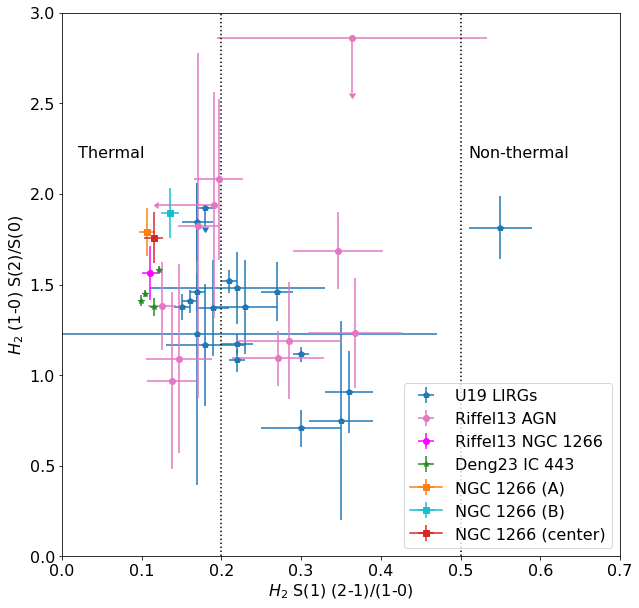

In [7]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

#plotting U19 galaxies, 1 upper limit to plot
ax.errorbar(ratio_21_10_U[noulim_ind_U], ratio_s2s0_U[noulim_ind_U], xerr=e_ratio_21_10_U[noulim_ind_U],
            yerr=e_ratio_s2s0_U[noulim_ind_U], marker='p', linestyle='', color='tab:blue', label='U19 LIRGs')
ax.errorbar(ratio_21_10_U[ulim_ind_s2s0_U], ratio_s2s0_U[ulim_ind_s2s0_U], yerr=0.1,
            xerr=e_ratio_21_10_U[ulim_ind_s2s0_U], uplims=True, marker='p', linestyle='', color='tab:blue')

#Riffel AGN
ax.errorbar(ratio_21_10_r13[noulim_s2s0_2110_r13_ind], ratio_s2s0_r13[noulim_s2s0_2110_r13_ind],
            xerr=e_ratio_21_10_r13[noulim_s2s0_2110_r13_ind], yerr=e_ratio_s2s0_r13[noulim_s2s0_2110_r13_ind],
            marker='o', linestyle='', label='Riffel13 AGN', color='tab:pink')
ax.errorbar(ratio_21_10_r13[ulim_2110_r13], ratio_s2s0_r13[ulim_2110_r13],
            xerr=np.array([0.07]), yerr=e_ratio_s2s0_r13[ulim_2110_r13],
            marker='o', linestyle='', xuplims=True, color='tab:pink')
ax.errorbar(ratio_21_10_r13[ulim_s2s0_r13], ratio_s2s0_r13[ulim_s2s0_r13],
            xerr=e_ratio_21_10_r13[ulim_s2s0_r13], yerr=np.array([0.3]), uplims=True,
            marker='o', linestyle='', color='tab:pink')

ax.errorbar(ratio_21_10_r13[7], ratio_s2s0_r13[7],
            xerr=e_ratio_21_10_r13[7],
            yerr=e_ratio_s2s0_r13[7], marker='o', linestyle='', color='magenta', label='Riffel13 NGC 1266')

#plotting Reunanen 2002 Seyferts, 1 upper limit to plot
#ax.errorbar(ratio_21_10_re02[noulim_re02], ratio_s2s0_re02[noulim_re02], xerr=e_ratio_21_10_re02[noulim_re02],
#            yerr=e_ratio_s2s0_re02[noulim_re02], marker='o', linestyle='', color='tab:olive', label='Reunanen02 Seyferts')
#ax.errorbar(ratio_21_10_re02[ulim_2110_re02], ratio_s2s0_re02[ulim_2110_re02], xerr=0.1,
#            yerr=e_ratio_s2s0_re02[ulim_2110_re02], xuplims=True, marker='o', linestyle='', color='tab:olive')

#plotting Rosenberg 2013 NGC 253
#ax.errorbar(ratio_21_10_ro13, ratio_s2s0_ro13, xerr=e_ratio_21_10_ro13,
#            yerr=e_ratio_s2s0_ro13, marker='o', linestyle='', color='tab:cyan', label='Rosenberg13 NGC 253')

#plotting Deng 23 IC 443
ax.errorbar(ratio_21_10_d23, ratio_s2s0_d23, xerr=e_ratio_21_10_d23,
            yerr=e_ratio_s2s0_d23, marker='*', linestyle='', color='forestgreen', label='Deng23 IC 443')


#NGC 1266 points
ax.errorbar(ratio_21_10_A, ratio_s2s0_A, xerr=ratio_21_10_A_err, yerr=ratio_s2s0_A_err,
            marker='s', label='NGC 1266 (A)', color='tab:orange')
ax.errorbar(ratio_21_10_B, ratio_s2s0_B, xerr=ratio_21_10_B_err, yerr=ratio_s2s0_B_err,
            marker='s', label='NGC 1266 (B)', color='tab:cyan')
ax.errorbar(ratio_21_10_ctr, ratio_s2s0_ctr, xerr=ratio_21_10_ctr_err, yerr=ratio_s2s0_ctr_err,
            marker='s', label='NGC 1266 (center)', color='tab:red')

ax.set_xlabel(r'$H_2$ S(1) (2-1)/(1-0)', fontsize=16)
ax.set_ylabel(r'$H_2$ (1-0) S(2)/S(0)', fontsize=16)

plt.legend(fontsize=16, loc='lower right')

ax.set_xlim(0,0.7)
ax.set_ylim(0,3)

ax.axvline(0.2, linestyle='dotted', color='k')
ax.axvline(0.5, linestyle='dotted', color='k')

ax.text(0.02, 2.2, 'Thermal', fontsize=16)
ax.text(0.51, 2.2, 'Non-thermal', fontsize=16)

ax.tick_params(axis='both', labelsize=16)

plt.savefig('plots/line_ratio_H2.png', dpi=500, bbox_inches='tight')


(500.0, 3000.0)

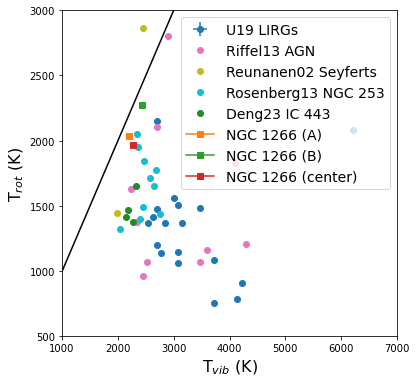

In [46]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(111)

ax.errorbar(Tvib_U[noulim_ind_U], Trot_U[noulim_ind_U], xerr=0, yerr=0,
            marker='o', linestyle='', label='U19 LIRGs')

ax.errorbar(Tvib_r13[noulim_s2s0_2110_r13_ind], Trot_r13[noulim_s2s0_2110_r13_ind],
            marker='o', linestyle='', color='tab:pink', label='Riffel13 AGN')

ax.errorbar(Tvib_re02[noulim_re02], Trot_re02[noulim_re02], 
            marker='o', linestyle='', color='tab:olive', label='Reunanen02 Seyferts')


ax.errorbar(Tvib_ro13, Trot_ro13,
            marker='o', linestyle='', color='tab:cyan', label='Rosenberg13 NGC 253')


ax.errorbar(Tvib_d23, Trot_d23,
            marker='o', linestyle='', color='forestgreen', label='Deng23 IC 443')


ax.errorbar(Tvib_A, Trot_A, marker='s', label='NGC 1266 (A)')
ax.errorbar(Tvib_B, Trot_B, marker='s', label='NGC 1266 (B)')
ax.errorbar(Tvib_ctr, Trot_ctr, marker='s', label='NGC 1266 (center)')

ax.set_xlabel(r'T$_{vib}$ (K)', fontsize=16)
ax.set_ylabel(r'T$_{rot}$ (K)', fontsize=16)

plt.legend(fontsize=14, loc='upper right')

ax.plot([0,10000], [0,10000], marker='', linestyle='-', color='k')

ax.set_xlim(1000,7000)
ax.set_ylim(500,3000)

/var/folders/vf/84glvj217td2j5kktzkvgpqr0000gn/T/ipykernel_61851/4184385907.py:8: RuntimeWarning: invalid value encountered in true_divide
  H2_brgamma_lirgs = U19['H2_1-0_S(1)_Flux']/U19['Brgamma_Flux']


[230.         144.11111111 401.7        473.125     ]


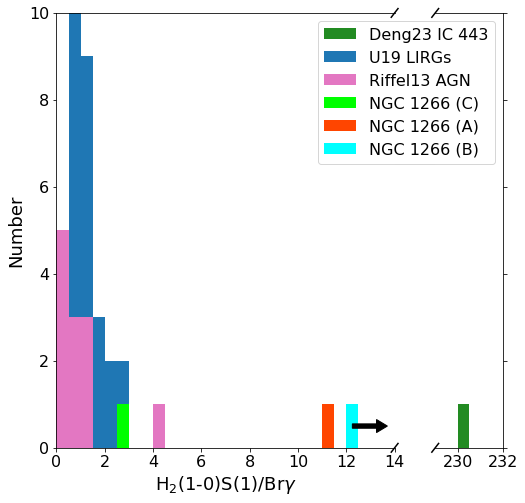

In [37]:
fig = plt.figure(figsize=(8,8))
gs = GridSpec(1,2, width_ratios=[5,1])
#fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,10))

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

H2_brgamma_lirgs = U19['H2_1-0_S(1)_Flux']/U19['Brgamma_Flux']
H2_brgamma_r13 = r13_10_S1/r13_brgamma

mask_ind = np.where(H2_brgamma_r13.mask == True)
r13_10_S1_nolim[7] = False
r13_10_S1_nolim[mask_ind] = False
H2_brgamma_r13_cut = H2_brgamma_r13[r13_10_S1_nolim]

H2_brgamma_d23 = d23_10_S1/d23_brgamma

print(H2_brgamma_d23)

full_H2_brgamma = np.concatenate((H2_brgamma_lirgs, H2_brgamma_r13_cut, [2.6]))
bins = np.arange(0,11.5,0.5)
full_H2_brgamma_hist, full_bins = np.histogram(full_H2_brgamma, bins)

U19_hist, bins = np.histogram(H2_brgamma_lirgs, bins=full_bins)
r13_hist, bins = np.histogram(H2_brgamma_r13_cut, bins=full_bins)

ax1.bar(full_bins[0:-1], full_H2_brgamma_hist, align='edge', width=0.5, label='U19 LIRGs', color='tab:blue')
ax1.bar(full_bins[0:-1], r13_hist, align='edge', width=0.5, label='Riffel13 AGN', color='tab:pink')

ax1.bar([2.5], [1], align='edge', width=0.5, color='lime', label='NGC 1266 (C)')
ax1.bar([11], [1], align='edge', width=0.5, color='orangered', label='NGC 1266 (A)')
ax1.bar([12], [1], align='edge', width=0.5, color='cyan', label='NGC 1266 (B)')

ax1.arrow(12.25, 0.5, 1, 0, width=0.1, fc='k')

ax1.set_ylabel('Number', fontsize=18)
ax1.set_xlabel(r'H$_2$(1-0)S(1)/Br$\gamma$', fontsize=18)

ax1.tick_params(labelsize=16)

ax1.set_xlim(0,14)
ax1.set_ylim(0,10)

ax2.set_ylim(0,10)
ax2.set_xlim(229,232)
ax2.bar([230], [1], align='edge', width=0.5, color='forestgreen', label='Deng23 IC 443')


ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
#ax1.xaxis.tick_top()
ax1.tick_params(labelright=False)  # don't put tick labels at the top
ax2.tick_params(labelleft=False, labelsize=16)
ax2.yaxis.tick_right()


d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (1-d, 1+d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # bottom-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the right axes
ax2.plot((-d*5, +d*5), (1 - d, 1 + d), **kwargs)  # top-left diagonal
ax2.plot((-d*5, +d*5), (-d, +d), **kwargs)  # bottom-right diagonal

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
for i in range(len(handles1)):
    handles2.append(handles1[i])
    labels2.append(labels1[i])

ax2.legend(handles2, labels2, fontsize=16)

plt.savefig('plots/H2_brgamma_histogram.png', dpi=500, bbox_inches='tight')

In [11]:
#main 50 pc center table
Noverg_10_S2, Eu_10_S2, Noverg_10_S2_err = calc_Noverg(tab_50pc['H2(1-0)S(2)_flux'][0], 'H2_10_S2', tab_50pc['H2(1-0)S(2)_flux_err'][0])
Noverg_10_S1, Eu_10_S1, Noverg_10_S1_err = calc_Noverg(tab_50pc['H2(1-0)S(1)_flux'][0], 'H2_10_S1', tab_50pc['H2(1-0)S(1)_flux_err'][0])
Noverg_10_S0, Eu_10_S0, Noverg_10_S0_err = calc_Noverg(tab_50pc['H2(1-0)S(0)_flux'][0], 'H2_10_S0', tab_50pc['H2(1-0)S(0)_flux_err'][0])
Noverg_21_S3, Eu_21_S3, Noverg_21_S3_err = calc_Noverg(tab_50pc['H2(2-1)S(3)_flux'][0], 'H2_21_S3', tab_50pc['H2(2-1)S(3)_flux_err'][0])
Noverg_21_S2, Eu_21_S2, Noverg_21_S2_err = calc_Noverg(tab_50pc['H2(2-1)S(2)_flux'][0], 'H2_21_S2', tab_50pc['H2(2-1)S(2)_flux_err'][0])
Noverg_21_S1, Eu_21_S1, Noverg_21_S1_err = calc_Noverg(tab_50pc['H2(2-1)S(1)_flux'][0], 'H2_21_S1', tab_50pc['H2(2-1)S(1)_flux_err'][0])
Noverg_10_Q1, Eu_10_Q1, Noverg_10_Q1_err = calc_Noverg(tab_50pc['H2(1-0)Q(1)_flux'][0], 'H2_10_Q1', tab_50pc['H2(1-0)Q(1)_flux_err'][0])

Noverg_10_S2_c1, Eu_10_S2 = calc_Noverg(tab_50pc['H2(1-0)S(2)_flux'][1], 'H2_10_S2')
Noverg_10_S1_c1, Eu_10_S1 = calc_Noverg(tab_50pc['H2(1-0)S(1)_flux'][1], 'H2_10_S1')
Noverg_10_S0_c1, Eu_10_S0 = calc_Noverg(tab_50pc['H2(1-0)S(0)_flux'][1], 'H2_10_S0')
Noverg_21_S3_c1, Eu_21_S3 = calc_Noverg(tab_50pc['H2(2-1)S(3)_flux'][1], 'H2_21_S3')
Noverg_21_S2_c1, Eu_21_S2 = calc_Noverg(tab_50pc['H2(2-1)S(2)_flux'][1], 'H2_21_S2')
Noverg_21_S1_c1, Eu_21_S1 = calc_Noverg(tab_50pc['H2(2-1)S(1)_flux'][1], 'H2_21_S1')

Noverg_10_S2_c2, Eu_10_S2 = calc_Noverg(tab_50pc['H2(1-0)S(2)_flux'][2], 'H2_10_S2')
Noverg_10_S1_c2, Eu_10_S1 = calc_Noverg(tab_50pc['H2(1-0)S(1)_flux'][2], 'H2_10_S1')
Noverg_10_S0_c2, Eu_10_S0 = calc_Noverg(tab_50pc['H2(1-0)S(0)_flux'][2], 'H2_10_S0')
Noverg_21_S3_c2, Eu_21_S3 = calc_Noverg(tab_50pc['H2(2-1)S(3)_flux'][2], 'H2_21_S3')
Noverg_21_S2_c2, Eu_21_S2 = calc_Noverg(tab_50pc['H2(2-1)S(2)_flux'][2], 'H2_21_S2')
Noverg_21_S1_c2, Eu_21_S1 = calc_Noverg(tab_50pc['H2(2-1)S(1)_flux'][2], 'H2_21_S1')


#annulus fluxes
Noverg_10_S2_ann, Eu_10_S2_ann = calc_Noverg(tab_ann['H2(1-0)S(2)_flux'][0], 'H2_10_S2')
Noverg_10_S1_ann, Eu_10_S1_ann = calc_Noverg(tab_ann['H2(1-0)S(1)_flux'][0], 'H2_10_S1')
Noverg_10_S0_ann, Eu_10_S0_ann = calc_Noverg(tab_ann['H2(1-0)S(0)_flux'][0], 'H2_10_S0')
Noverg_21_S3_ann, Eu_21_S3_ann = calc_Noverg(tab_ann['H2(2-1)S(3)_flux'][0], 'H2_21_S3')
Noverg_21_S2_ann, Eu_21_S2_ann = calc_Noverg(tab_ann['H2(2-1)S(2)_flux'][0], 'H2_21_S2')
Noverg_21_S1_ann, Eu_21_S1_ann = calc_Noverg(tab_ann['H2(2-1)S(1)_flux'][0], 'H2_21_S1')


#A table:
Noverg_10_S2_A, Eu_10_S2, Noverg_10_S2_err_A = calc_Noverg(tab_A['H2(1-0)S(2)_flux'][0], 'H2_10_S2', tab_A['H2(1-0)S(2)_flux_err'][0])
Noverg_10_S1_A, Eu_10_S1, Noverg_10_S1_err_A = calc_Noverg(tab_A['H2(1-0)S(1)_flux'][0], 'H2_10_S1', tab_A['H2(1-0)S(1)_flux_err'][0])
Noverg_10_S0_A, Eu_10_S0, Noverg_10_S0_err_A = calc_Noverg(tab_A['H2(1-0)S(0)_flux'][0], 'H2_10_S0', tab_A['H2(1-0)S(0)_flux_err'][0])
Noverg_21_S3_A, Eu_21_S3, Noverg_21_S3_err_A = calc_Noverg(tab_A['H2(2-1)S(3)_flux'][0], 'H2_21_S3', tab_A['H2(2-1)S(3)_flux_err'][0])
Noverg_21_S2_A, Eu_21_S2, Noverg_21_S2_err_A = calc_Noverg(tab_A['H2(2-1)S(2)_flux'][0], 'H2_21_S2', tab_A['H2(2-1)S(2)_flux_err'][0])
Noverg_21_S1_A, Eu_21_S1, Noverg_21_S1_err_A = calc_Noverg(tab_A['H2(2-1)S(1)_flux'][0], 'H2_21_S1', tab_A['H2(2-1)S(1)_flux_err'][0])
Noverg_10_Q1_A, Eu_10_Q1, Noverg_10_Q1_err_A = calc_Noverg(tab_A['H2(1-0)Q(1)_flux'][0], 'H2_10_Q1', tab_A['H2(1-0)Q(1)_flux_err'][0])

Noverg_10_S2_c1_A, Eu_10_S2 = calc_Noverg(tab_A['H2(1-0)S(2)_flux'][1], 'H2_10_S2')
Noverg_10_S1_c1_A, Eu_10_S1 = calc_Noverg(tab_A['H2(1-0)S(1)_flux'][1], 'H2_10_S1')
Noverg_10_S0_c1_A, Eu_10_S0 = calc_Noverg(tab_A['H2(1-0)S(0)_flux'][1], 'H2_10_S0')
Noverg_21_S3_c1_A, Eu_21_S3 = calc_Noverg(tab_A['H2(2-1)S(3)_flux'][1], 'H2_21_S3')
Noverg_21_S2_c1_A, Eu_21_S2 = calc_Noverg(tab_A['H2(2-1)S(2)_flux'][1], 'H2_21_S2')
Noverg_21_S1_c1_A, Eu_21_S1 = calc_Noverg(tab_A['H2(2-1)S(1)_flux'][1], 'H2_21_S1')

Noverg_10_S2_c2_A, Eu_10_S2 = calc_Noverg(tab_A['H2(1-0)S(2)_flux'][2], 'H2_10_S2')
Noverg_10_S1_c2_A, Eu_10_S1 = calc_Noverg(tab_A['H2(1-0)S(1)_flux'][2], 'H2_10_S1')
Noverg_10_S0_c2_A, Eu_10_S0 = calc_Noverg(tab_A['H2(1-0)S(0)_flux'][2], 'H2_10_S0')
Noverg_21_S3_c2_A, Eu_21_S3 = calc_Noverg(tab_A['H2(2-1)S(3)_flux'][2], 'H2_21_S3')
Noverg_21_S2_c2_A, Eu_21_S2 = calc_Noverg(tab_A['H2(2-1)S(2)_flux'][2], 'H2_21_S2')
Noverg_21_S1_c2_A, Eu_21_S1 = calc_Noverg(tab_A['H2(2-1)S(1)_flux'][2], 'H2_21_S1')

#B table:
Noverg_10_S2_B, Eu_10_S2, Noverg_10_S2_err_B = calc_Noverg(tab_B['H2(1-0)S(2)_flux'][0], 'H2_10_S2', tab_B['H2(1-0)S(2)_flux_err'][0])
Noverg_10_S1_B, Eu_10_S1, Noverg_10_S1_err_B = calc_Noverg(tab_B['H2(1-0)S(1)_flux'][0], 'H2_10_S1', tab_B['H2(1-0)S(1)_flux_err'][0])
Noverg_10_S0_B, Eu_10_S0, Noverg_10_S0_err_B = calc_Noverg(tab_B['H2(1-0)S(0)_flux'][0], 'H2_10_S0', tab_B['H2(1-0)S(0)_flux_err'][0])
Noverg_21_S3_B, Eu_21_S3, Noverg_21_S3_err_B = calc_Noverg(tab_B['H2(2-1)S(3)_flux'][0], 'H2_21_S3', tab_B['H2(2-1)S(3)_flux_err'][0])
Noverg_21_S2_B, Eu_21_S2, Noverg_21_S2_err_B = calc_Noverg(tab_B['H2(2-1)S(2)_flux'][0], 'H2_21_S2', tab_B['H2(2-1)S(2)_flux_err'][0])
Noverg_21_S1_B, Eu_21_S1, Noverg_21_S1_err_B = calc_Noverg(tab_B['H2(2-1)S(1)_flux'][0], 'H2_21_S1', tab_B['H2(2-1)S(1)_flux_err'][0])
Noverg_10_Q1_B, Eu_10_Q1, Noverg_10_Q1_err_B = calc_Noverg(tab_B['H2(1-0)Q(1)_flux'][0], 'H2_10_Q1', tab_B['H2(1-0)Q(1)_flux_err'][0])

Noverg_10_S2_c1_B, Eu_10_S2 = calc_Noverg(tab_B['H2(1-0)S(2)_flux'][1], 'H2_10_S2')
Noverg_10_S1_c1_B, Eu_10_S1 = calc_Noverg(tab_B['H2(1-0)S(1)_flux'][1], 'H2_10_S1')
Noverg_10_S0_c1_B, Eu_10_S0 = calc_Noverg(tab_B['H2(1-0)S(0)_flux'][1], 'H2_10_S0')
Noverg_21_S3_c1_B, Eu_21_S3 = calc_Noverg(tab_B['H2(2-1)S(3)_flux'][1], 'H2_21_S3')
Noverg_21_S2_c1_B, Eu_21_S2 = calc_Noverg(tab_B['H2(2-1)S(2)_flux'][1], 'H2_21_S2')
Noverg_21_S1_c1_B, Eu_21_S1 = calc_Noverg(tab_B['H2(2-1)S(1)_flux'][1], 'H2_21_S1')

Noverg_10_S2_c2_B, Eu_10_S2 = calc_Noverg(tab_B['H2(1-0)S(2)_flux'][2], 'H2_10_S2')
Noverg_10_S1_c2_B, Eu_10_S1 = calc_Noverg(tab_B['H2(1-0)S(1)_flux'][2], 'H2_10_S1')
Noverg_10_S0_c2_B, Eu_10_S0 = calc_Noverg(tab_B['H2(1-0)S(0)_flux'][2], 'H2_10_S0')
Noverg_21_S3_c2_B, Eu_21_S3 = calc_Noverg(tab_B['H2(2-1)S(3)_flux'][2], 'H2_21_S3')
Noverg_21_S2_c2_B, Eu_21_S2 = calc_Noverg(tab_B['H2(2-1)S(2)_flux'][2], 'H2_21_S2')
Noverg_21_S1_c2_B, Eu_21_S1 = calc_Noverg(tab_B['H2(2-1)S(1)_flux'][2], 'H2_21_S1')

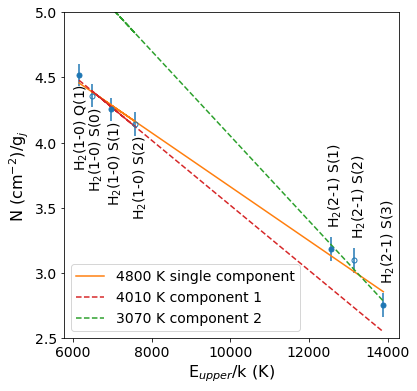

In [16]:
#excitation diagram
#extract excitation properties in center for 50pc aperture

fig = plt.figure(figsize=(6,6))
level_pops = [Noverg_10_Q1.value, Noverg_10_S2.value, Noverg_10_S1.value, Noverg_10_S0.value, 
              Noverg_21_S1.value, Noverg_21_S2.value, Noverg_21_S3.value]
level_pops_err = [Noverg_10_Q1_err.value, Noverg_10_S2_err.value, Noverg_10_S1_err.value, Noverg_10_S0_err.value, 
              Noverg_21_S1_err.value, Noverg_21_S2_err.value, Noverg_21_S3_err.value]
energy_lvls = np.array([Eu_10_Q1, Eu_10_S2, Eu_10_S1, Eu_10_S0, Eu_21_S1, Eu_21_S2, Eu_21_S3])
labels = [r'H$_2$(1-0) Q(1)', r'H$_2$(1-0) S(2)', r'H$_2$(1-0) S(1)', r'H$_2$(1-0) S(0)',
         r'H$_2$(2-1) S(1)', r'H$_2$(2-1) S(2)', r'H$_2$(2-1) S(3)']

level_pops_ortho = [Noverg_10_S1.value, Noverg_21_S1.value, Noverg_21_S3.value, Noverg_10_Q1.value]
level_pops_ortho_err = [Noverg_10_S1_err.value, Noverg_21_S1_err.value, Noverg_21_S3_err.value, Noverg_10_Q1_err.value]
energy_lvls_ortho = np.array([Eu_10_S1, Eu_21_S1, Eu_21_S3, Eu_10_Q1])
labels_ortho = [r'H$_2$(1-0) S(1)', r'H$_2$(2-1) S(1)', r'H$_2$(2-1) S(3)', r'H$_2$(1-0) Q(1)']

level_pops_para = [Noverg_10_S2.value, Noverg_10_S0.value, Noverg_21_S2.value]
level_pops_para_err = [Noverg_10_S2_err.value, Noverg_10_S0_err.value, Noverg_21_S2_err.value]
energy_lvls_para = np.array([Eu_10_S2, Eu_10_S0, Eu_21_S2])
labels_para = [r'H$_2$(1-0) S(2)', r'H$_2$(1-0) S(0)', r'H$_2$(2-1) S(2)']

level_pops_ann = [Noverg_10_S2_ann.value, Noverg_10_S1_ann.value, Noverg_10_S0_ann.value, 
              Noverg_21_S1_ann.value, Noverg_21_S2_ann.value, Noverg_21_S3_ann.value]
energy_lvls_ann = [Eu_10_S2_ann, Eu_10_S1_ann, Eu_10_S0_ann, Eu_21_S1_ann, Eu_21_S2_ann, Eu_21_S3_ann]

log_Ng = np.log10(level_pops)
log_Ng_err = level_pops_err/(np.array(level_pops)*np.log(10))
log_Ng_ortho = np.log10(level_pops_ortho)
log_Ng_ortho_err = level_pops_ortho_err/(np.array(level_pops_ortho)*np.log(10))
log_Ng_para = np.log10(level_pops_para)
log_Ng_para_err = level_pops_para_err/(np.array(level_pops_para)*np.log(10))

for i in range(len(energy_lvls)):
    if energy_lvls[i] < 10000:
        yval = log_Ng[i] - 0.7
    else:
        yval = log_Ng[i] + 0.2
        
    if i == 0:
        xval = energy_lvls[i]-150
    else:
        xval = energy_lvls[i]-100
    plt.text(xval, yval, labels[i], rotation='vertical', fontsize=14)

plt.errorbar(energy_lvls_ortho, log_Ng_ortho, yerr=log_Ng_ortho_err, marker='o', linestyle='', color='tab:blue', markersize=5)
plt.errorbar(energy_lvls_para, log_Ng_para, yerr=log_Ng_para_err, marker='o', linestyle='', color='tab:blue', fillstyle='none', markersize=5)

##linear fitting
popt, pcov = curve_fit(linfunc, energy_lvls, log_Ng, sigma=log_Ng_err, absolute_sigma=True)

plt.plot(energy_lvls, linfunc(energy_lvls, popt[0], popt[1]), color='tab:orange', label=f'{int(-np.round(1/popt[0], -2))} K single component')

popt_first, pcov_first = curve_fit(linfunc, energy_lvls[0:4], log_Ng[0:4], sigma=log_Ng_err[0:4], absolute_sigma=True)
popt_end, pcov_end = curve_fit(linfunc, energy_lvls[4:7], log_Ng[4:7], sigma=log_Ng_err[4:7], absolute_sigma=True)

plt.plot(energy_lvls, linfunc(energy_lvls, popt_first[0], popt_first[1]), 
         color='tab:red', label=f'{int(-np.round(1/popt_first[0], -1))} K component 1', linestyle='--')
plt.plot(energy_lvls, linfunc(energy_lvls, popt_end[0], popt_end[1]),
         color='tab:green', label=f'{int(-np.round(1/popt_end[0], -1))} K component 2', linestyle='--')



plt.legend(fontsize=14)

plt.xticks([6000, 8000, 10000, 12000, 14000],fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'N (cm$^{-2}$)/g$_j$', fontsize=16)

plt.xlabel(r'E$_{upper}$/k (K)', fontsize=16)

plt.ylim(2.5,5)

plt.savefig('plots/excitation_diagram_cent_50pc.png', bbox_inches='tight')


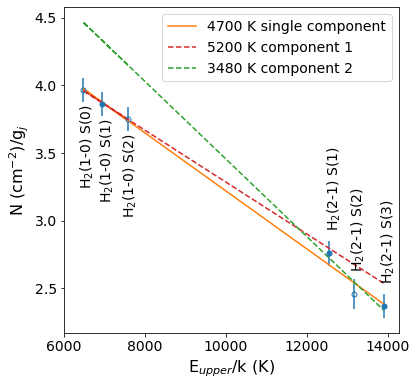

In [17]:
#excitation diagram
#extract excitation properties in center for A aperture

fig = plt.figure(figsize=(6,6))
level_pops = [Noverg_10_S2_A.value, Noverg_10_S1_A.value, Noverg_10_S0_A.value, 
              Noverg_21_S1_A.value, Noverg_21_S2_A.value, Noverg_21_S3_A.value]
level_pops_err = [Noverg_10_S2_err_A.value, Noverg_10_S1_err_A.value, Noverg_10_S0_err_A.value, 
              Noverg_21_S1_err_A.value, Noverg_21_S2_err_A.value, Noverg_21_S3_err_A.value]
energy_lvls = np.array([Eu_10_S2, Eu_10_S1, Eu_10_S0, Eu_21_S1, Eu_21_S2, Eu_21_S3])
labels = [r'H$_2$(1-0) S(2)', r'H$_2$(1-0) S(1)', r'H$_2$(1-0) S(0)',
         r'H$_2$(2-1) S(1)', r'H$_2$(2-1) S(2)', r'H$_2$(2-1) S(3)']

level_pops_ortho = [Noverg_10_S1_A.value, Noverg_21_S1_A.value, Noverg_21_S3_A.value]
level_pops_ortho_err = [Noverg_10_S1_err_A.value, Noverg_21_S1_err_A.value, Noverg_21_S3_err_A.value]
energy_lvls_ortho = np.array([Eu_10_S1, Eu_21_S1, Eu_21_S3])
labels_ortho = [r'H$_2$(1-0) S(1)', r'H$_2$(2-1) S(1)', r'H$_2$(2-1) S(3)']

level_pops_para = [Noverg_10_S2_A.value, Noverg_10_S0_A.value, Noverg_21_S2_A.value]
level_pops_para_err = [Noverg_10_S2_err_A.value, Noverg_10_S0_err_A.value, Noverg_21_S2_err_A.value]
energy_lvls_para = np.array([Eu_10_S2, Eu_10_S0, Eu_21_S2])
labels_para = [r'H$_2$(1-0) S(2)', r'H$_2$(1-0) S(0)', r'H$_2$(2-1) S(2)']

log_Ng = np.log10(level_pops)
log_Ng_err = level_pops_err/(np.array(level_pops)*np.log(10))
log_Ng_ortho = np.log10(level_pops_ortho)
log_Ng_ortho_err = level_pops_ortho_err/(np.array(level_pops_ortho)*np.log(10))
log_Ng_para = np.log10(level_pops_para)
log_Ng_para_err = level_pops_para_err/(np.array(level_pops_para)*np.log(10))

for i in range(len(energy_lvls)):
    if energy_lvls[i] < 10000:
        yval = log_Ng[i] - 0.7
    else:
        yval = log_Ng[i] + 0.2
        
    if i == 0:
        xval = energy_lvls[i]-150
    else:
        xval = energy_lvls[i]-100
    plt.text(xval, yval, labels[i], rotation='vertical', fontsize=14)

plt.errorbar(energy_lvls_ortho, log_Ng_ortho, yerr=log_Ng_ortho_err, marker='o', linestyle='', color='tab:blue', markersize=5)
plt.errorbar(energy_lvls_para, log_Ng_para, yerr=log_Ng_para_err, marker='o', linestyle='', color='tab:blue', fillstyle='none', markersize=5)

##linear fitting
popt, pcov = curve_fit(linfunc, energy_lvls, log_Ng, sigma=log_Ng_err, absolute_sigma=True)

plt.plot(energy_lvls, linfunc(energy_lvls, popt[0], popt[1]), color='tab:orange', label=f'{int(-np.round(1/popt[0], -2))} K single component')

popt_first, pcov_first = curve_fit(linfunc, energy_lvls[0:3], log_Ng[0:3], sigma=log_Ng_err[0:3], absolute_sigma=True)
popt_end, pcov_end = curve_fit(linfunc, energy_lvls[3:6], log_Ng[3:6], sigma=log_Ng_err[3:6], absolute_sigma=True)

plt.plot(energy_lvls, linfunc(energy_lvls, popt_first[0], popt_first[1]), 
         color='tab:red', label=f'{int(-np.round(1/popt_first[0], -1))} K component 1', linestyle='--')
plt.plot(energy_lvls, linfunc(energy_lvls, popt_end[0], popt_end[1]),
         color='tab:green', label=f'{int(-np.round(1/popt_end[0], -1))} K component 2', linestyle='--')



plt.legend(fontsize=14)

plt.xticks([6000, 8000, 10000, 12000, 14000],fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'N (cm$^{-2}$)/g$_j$', fontsize=16)

plt.xlabel(r'E$_{upper}$/k (K)', fontsize=16)

#plt.ylim(3,5)

plt.savefig('plots/excitation_diagram_A_ap.png', bbox_inches='tight')


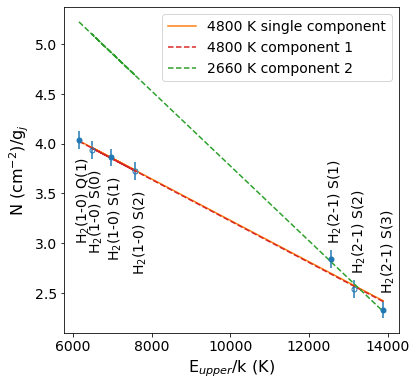

In [18]:
#excitation diagram
#extract excitation properties in center for A aperture

fig = plt.figure(figsize=(6,6))
level_pops = [Noverg_10_Q1_B.value, Noverg_10_S2_B.value, Noverg_10_S1_B.value, Noverg_10_S0_B.value, 
              Noverg_21_S1_B.value, Noverg_21_S2_B.value, Noverg_21_S3_B.value]
level_pops_err = [Noverg_10_Q1_err_B.value, Noverg_10_S2_err_B.value, Noverg_10_S1_err_B.value, Noverg_10_S0_err_B.value, 
              Noverg_21_S1_err_B.value, Noverg_21_S2_err_B.value, Noverg_21_S3_err_B.value]
energy_lvls = np.array([Eu_10_Q1, Eu_10_S2, Eu_10_S1, Eu_10_S0, Eu_21_S1, Eu_21_S2, Eu_21_S3])
labels = [r'H$_2$(1-0) Q(1)', r'H$_2$(1-0) S(2)', r'H$_2$(1-0) S(1)', r'H$_2$(1-0) S(0)',
         r'H$_2$(2-1) S(1)', r'H$_2$(2-1) S(2)', r'H$_2$(2-1) S(3)']

level_pops_ortho = [Noverg_10_S1_B.value, Noverg_21_S1_B.value, Noverg_21_S3_B.value, Noverg_10_Q1_B.value]
level_pops_ortho_err = [Noverg_10_S1_err_B.value, Noverg_21_S1_err_B.value, Noverg_21_S3_err_B.value, Noverg_10_Q1_err_B.value]
energy_lvls_ortho = np.array([Eu_10_S1, Eu_21_S1, Eu_21_S3, Eu_10_Q1])
labels_ortho = [r'H$_2$(1-0) S(1)', r'H$_2$(2-1) S(1)', r'H$_2$(2-1) S(3)', r'H$_2$(1-0) Q(1)']

level_pops_para = [Noverg_10_S2_B.value, Noverg_10_S0_B.value, Noverg_21_S2_B.value]
level_pops_para_err = [Noverg_10_S2_err_B.value, Noverg_10_S0_err_B.value, Noverg_21_S2_err_B.value]
energy_lvls_para = np.array([Eu_10_S2, Eu_10_S0, Eu_21_S2])
labels_para = [r'H$_2$(1-0) S(2)', r'H$_2$(1-0) S(0)', r'H$_2$(2-1) S(2)']

log_Ng = np.log10(level_pops)
log_Ng_err = level_pops_err/(np.array(level_pops)*np.log(10))
log_Ng_ortho = np.log10(level_pops_ortho)
log_Ng_ortho_err = level_pops_ortho_err/(np.array(level_pops_ortho)*np.log(10))
log_Ng_para = np.log10(level_pops_para)
log_Ng_para_err = level_pops_para_err/(np.array(level_pops_para)*np.log(10))

for i in range(len(energy_lvls)):
    if energy_lvls[i] < 10000:
        yval = log_Ng[i] - 1
    else:
        yval = log_Ng[i] + 0.2
        
    #if i == 0:
    #    xval = energy_lvls[i]-150
    #else:
    xval = energy_lvls[i]-100
    plt.text(xval, yval, labels[i], rotation='vertical', fontsize=14)

plt.errorbar(energy_lvls_ortho, log_Ng_ortho, yerr=log_Ng_ortho_err, marker='o', linestyle='', color='tab:blue', markersize=5)
plt.errorbar(energy_lvls_para, log_Ng_para, yerr=log_Ng_para_err, marker='o', linestyle='', color='tab:blue', fillstyle='none', markersize=5)

##linear fitting
popt, pcov = curve_fit(linfunc, energy_lvls, log_Ng, sigma=log_Ng_err, absolute_sigma=True)

plt.plot(energy_lvls, linfunc(energy_lvls, popt[0], popt[1]), color='tab:orange', label=f'{int(-np.round(1/popt[0], -2))} K single component')

popt_first, pcov_first = curve_fit(linfunc, energy_lvls[0:4], log_Ng[0:4], sigma=log_Ng_err[0:4], absolute_sigma=True)
popt_end, pcov_end = curve_fit(linfunc, energy_lvls[4:7], log_Ng[4:7], sigma=log_Ng_err[4:7], absolute_sigma=True)

plt.plot(energy_lvls, linfunc(energy_lvls, popt_first[0], popt_first[1]), 
         color='tab:red', label=f'{int(-np.round(1/popt_first[0], -1))} K component 1', linestyle='--')
plt.plot(energy_lvls, linfunc(energy_lvls, popt_end[0], popt_end[1]),
         color='tab:green', label=f'{int(-np.round(1/popt_end[0], -1))} K component 2', linestyle='--')



plt.legend(fontsize=14)

plt.xticks([6000, 8000, 10000, 12000, 14000],fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel(r'N (cm$^{-2}$)/g$_j$', fontsize=16)

plt.xlabel(r'E$_{upper}$/k (K)', fontsize=16)

#plt.ylim(3,5)

plt.savefig('plots/excitation_diagram_B_ap.png', bbox_inches='tight')


# OPR calculations

In [19]:
#calculate ortho to para ratio with v=1

#format - A, wavelength, Eupper, J
line_dict = {'H2_10_S2':[3.98e-7, 2.0338, 7584, 4], 'H2_10_S1':[3.47e-7, 2.1218, 6956, 3],
            'H2_10_S0':[2.53e-7, 2.2235, 6471, 2], 'H2_21_S1':[4.98e-7, 2.2477, 12550, 3],
            'H2_21_S2':[5.60e-7, 2.1542, 13150, 2], 'H2_21_S3':[5.77e-7, 2.0735, 13890, 5],
            'H2_10_Q1':[4.29e-7, 2.4066, 6149, 1]}

H2_10_S2_flux = tab_100pc['H2(1-0)S(2)_flux'][0]
H2_10_S2_flux_err = tab_100pc['H2(1-0)S(2)_flux_err'][0]
H2_10_S1_flux = tab_100pc['H2(1-0)S(1)_flux'][0]
H2_10_S1_flux_err = tab_100pc['H2(1-0)S(1)_flux_err'][0]
H2_10_S0_flux = tab_100pc['H2(1-0)S(0)_flux'][0]
H2_10_S0_flux_err = tab_100pc['H2(1-0)S(0)_flux_err'][0]

E_10_S2 = 7584
E_10_S1 = 6956
E_10_S0 = 6471
A_10_S2 = 3.98e-7
A_10_S1 = 3.47e-7
A_10_S0 = 2.53e-7
lambda_10_S2 = 2.0338
lambda_10_S1 = 2.1218
lambda_10_S0 = 2.2235
g_S2 = 9
g_S0 = 5
J_S1 = 3
J_S0 = 2

Trot_eqn = -1113/np.log(0.323*H2_10_S2_flux/H2_10_S0_flux) * u.K #eqn from U19, Reunanen02
#can also derive this easily by taking 1/slope between the two points

delta_E = - E_10_S0 + E_10_S2
log_coeff = (lambda_10_S0 * A_10_S2 * g_S2)/(lambda_10_S2 * A_10_S0 * g_S0)
Trot = delta_E / np.log(log_coeff * (H2_10_S0_flux / H2_10_S2_flux))

Trot_err_f1 = -delta_E/(H2_10_S0_flux * (np.log(log_coeff * (H2_10_S0_flux / H2_10_S2_flux)))**2) * H2_10_S0_flux_err
Trot_err_f2 = -delta_E/(H2_10_S2_flux * (np.log(log_coeff * (H2_10_S0_flux / H2_10_S2_flux)))**2) * H2_10_S2_flux_err
Trot_err = np.sqrt(Trot_err_f1**2 + Trot_err_f2**2)

delta_E_op = - E_10_S0 + E_10_S1

gratio_coeff = ((2*J_S0+1)/(2*J_S1+1)) * ((lambda_10_S1 * A_10_S0)/(lambda_10_S0 * A_10_S1))
gratio = gratio_coeff * (H2_10_S1_flux/H2_10_S0_flux)*np.exp(delta_E_op/Trot)

gratio_err_F1 = gratio_coeff * (1/H2_10_S0_flux) * np.exp(delta_E_op/Trot) * H2_10_S1_flux_err
gratio_err_F2 = gratio_coeff * (H2_10_S1_flux/(H2_10_S0_flux**2)) * np.exp(delta_E_op/Trot) * H2_10_S0_flux_err
gratio_err_Trot = gratio_coeff * (H2_10_S1_flux/H2_10_S0_flux)*np.exp(delta_E_op/Trot) * (-delta_E_op/(Trot**2)) * Trot_err

gratio_err = np.sqrt(gratio_err_F1**2 + gratio_err_F2**2 + gratio_err_Trot**2)

print(Trot)
print(Trot_err)
print(gratio)
print(gratio_err)

2053.622765081111
232.9073961738826
2.8958653079987404
0.1299367895787028


In [20]:
#calculate ortho to para ratio with v=2

#format - A, wavelength, Eupper, J
line_dict = {'H2_10_S2':[3.98e-7, 2.0338, 7584, 4], 'H2_10_S1':[3.47e-7, 2.1218, 6956, 3],
            'H2_10_S0':[2.53e-7, 2.2235, 6471, 2], 'H2_21_S1':[4.98e-7, 2.2477, 12550, 3],
            'H2_21_S2':[5.60e-7, 2.1542, 13150, 2], 'H2_21_S3':[5.77e-7, 2.0735, 13890, 5],
            'H2_10_Q1':[4.29e-7, 2.4066, 6149, 1]}

H2_21_S3_flux = tab_100pc['H2(2-1)S(3)_flux'][0]
H2_21_S3_flux_err = tab_100pc['H2(2-1)S(3)_flux_err'][0]
H2_21_S2_flux = tab_100pc['H2(2-1)S(2)_flux'][0]
H2_21_S2_flux_err = tab_100pc['H2(2-1)S(2)_flux_err'][0]
H2_21_S1_flux = tab_100pc['H2(2-1)S(1)_flux'][0]
H2_21_S1_flux_err = tab_100pc['H2(2-1)S(1)_flux_err'][0]

E_21_S3 = 13890
E_21_S2 = 13150
E_21_S1 = 12550
A_21_S3 = 5.77e-7
A_21_S2 = 5.60e-7
A_21_S1 = 4.98e-7
lambda_21_S3 = 2.0735
lambda_21_S2 = 2.1542
lambda_21_S1 = 2.2477
g_S3 = 33
g_S1 = 21
J_S2 = 2
J_S1 = 3

#calculating Trot
delta_E = - E_21_S1 + E_21_S3
log_coeff = (lambda_21_S1 * A_21_S3 * g_S3)/(lambda_21_S3 * A_21_S1 * g_S1)
Trot = delta_E / np.log(log_coeff * (H2_21_S1_flux / H2_21_S3_flux))

Trot_err_f1 = -delta_E/(H2_21_S1_flux * (np.log(log_coeff * (H2_21_S1_flux / H2_21_S3_flux)))**2) * H2_21_S1_flux_err
Trot_err_f2 = -delta_E/(H2_21_S3_flux * (np.log(log_coeff * (H2_21_S1_flux / H2_21_S3_flux)))**2) * H2_21_S3_flux_err
Trot_err = np.sqrt(Trot_err_f1**2 + Trot_err_f2**2)

#calculating OPR
delta_E_op = - E_21_S1 + E_21_S2

gratio_coeff = ((2*J_S2+1)/(2*J_S1+1)) * ((lambda_21_S1 * A_21_S2)/(lambda_21_S2 * A_21_S1))
gratio = gratio_coeff * (H2_21_S1_flux/H2_21_S2_flux)*np.exp(delta_E_op/Trot)

gratio_err_F1 = gratio_coeff * (1/H2_21_S2_flux) * np.exp(delta_E_op/Trot) * H2_21_S1_flux_err
gratio_err_F2 = gratio_coeff * (H2_21_S1_flux/(H2_21_S2_flux**2)) * np.exp(delta_E_op/Trot) * H2_21_S2_flux_err
gratio_err_Trot = gratio_coeff * (H2_21_S1_flux/H2_21_S2_flux)*np.exp(delta_E_op/Trot) * (-delta_E_op/(Trot**2)) * Trot_err

gratio_err = np.sqrt(gratio_err_F1**2 + gratio_err_F2**2 + gratio_err_Trot**2)

print(Trot)
print(Trot_err)
print(gratio)
print(gratio_err)

1354.1542330599166
196.29787040030914
4.6115189528026175
0.7254134176115429


In [21]:
gratio - 3*gratio_err

2.4352786999679887

# SFR calculations

In [ ]:
riffel_Cext = 1.35 #derived extinction coefficient from Riffel2017

In [55]:
#SEE Calzetti 2001, Table 2
#Using equation from U19
wave_brg = 2.166 #brgamma micron
wave_pab = 1.2820 #PaBeta microns

F_brg = 1.4
F_pab = 0.75

k_brg = 0.36
delta_k = 0.457
Lbrg_Lpab = 0.175

EBV = 2.5/delta_k * np.log10((F_brg/F_pab)/Lbrg_Lpab)

A_brg = k_brg * EBV

print(A_brg)

2.0245642259085757


In [85]:
## from Busch 2017
Av = 11.52 * np.log10(5.89/(F_pab/F_brg))
Rv = 3.1

EBV_2 = Av / Rv

A_brg_2 = k_brg * EBV_2

print(A_brg, A_brg_2)

#this second one is consistent w what Riffel derive!

2.0245642259085757 1.3929000866347736


In [87]:
L_brg_obs = (tab_50pc['Brgamma_flux'][0] * u.erg/u.s/u.cm**2 * 4 * np.pi * D_L**2).to(u.Lsun)
L_brg_corr = L_brg_obs * (10**(0.4*A_brg_2))

#U19, adopted from Kennicutt 1998

SFR_obs = (8.2e-40 *u.Msun/u.yr / (u.erg/u.s) * L_brg_obs).to(u.Msun/u.yr)
SFR_corr = (8.2e-40 *u.Msun/u.yr / (u.erg/u.s) * L_brg_corr).to(u.Msun/u.yr)

print(SFR_obs, SFR_corr)

sigma_SFR_corr = SFR_corr / (np.pi * (0.05*u.kpc)**2)

0.0789845551345399 solMass / yr 0.28490640389169253 solMass / yr


In [88]:
sigma_SFR_corr, np.log10(sigma_SFR_corr.value)


(<Quantity 36.27541 solMass / (kpc2 yr)>, 1.559612329696991)

In [89]:
ks_sigma_sfr = 10**2.1 * u.Msun / u.yr / u.kpc**2
ks_sigma_sfr

<Quantity 125.89254118 solMass / (kpc2 yr)>

In [90]:
0.1*u.kpc * as_per_kpc

<Quantity 0.66870247 arcsec>

In [20]:
galv = np.log(z+1)*const.c.to(u.km/u.s)
print(galv.value - 1450, galv.value -2650)

704.9392381992543 -495.0607618007457


In [67]:
NHIH2 = 5.8e21 * u.cm**-2 * EBV
print(NHIH2)

3.261797919519372e+22 1 / cm2
